# Model Comparison: Logistic Regression vs MLP vs CNN

This notebook extracts and compares results from three models:
- Logistic Regression (sklearn)
- MLP (PyTorch)
- CNN (PyTorch)

All models use the `laplacian_stft` preprocessor.


In [4]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [17]:
def load_results_from_json(file_path, model_name):
    """Load fold-level results from a JSON file."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    results = []
    eval_results = data.get("evaluation_results", {})
    
    for subject_key, subject_data in eval_results.items():
        if subject_key.startswith("btbank"):
            parts = subject_key.replace("btbank", "").split("_")
            if len(parts) == 2:
                subject_id = int(parts[0])
                trial_id = int(parts[1])
            else:
                continue
        else:
            continue
            
        population_results = subject_data.get("population", {})
        
        # Extract eval_name from config
        eval_name = "_".join(file_path.split(".")[0].split("/")[-1].split("_")[3:])
        
        # Check if we have folds directly or nested in one_second_after_onset
        if "one_second_after_onset" in population_results:
            one_second = population_results["one_second_after_onset"]
            folds = one_second.get("folds", [])
            for fold_idx, fold_result in enumerate(folds):
                results.append({
                    "model_name": model_name,
                    "eval_name": eval_name,
                    "subject_id": subject_id,
                    "trial_id": trial_id,
                    "fold_idx": fold_result.get("fold_idx", fold_idx),
                    "train_accuracy": fold_result.get("train_accuracy", np.nan),
                    "train_roc_auc": fold_result.get("train_roc_auc", np.nan),
                    "test_accuracy": fold_result.get("test_accuracy", np.nan),
                    "test_roc_auc": fold_result.get("test_roc_auc", np.nan),
                })
    
    return results


def load_all_results_for_model(base_dir, model_name):
    """Load all JSON files for a given model."""
    pattern = f"{base_dir}/eval_results/**/*.json"
    json_files = glob(pattern, recursive=True)
    
    all_results = []
    for json_file in json_files:
        try:
            results = load_results_from_json(json_file, model_name)
            all_results.extend(results)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    return pd.DataFrame(all_results)


In [18]:
# Define base directories
base_dir = Path("outputs")

# Load results for each model
print("Loading Logistic Regression results...")
df_logistic = load_all_results_for_model(base_dir / "run_all_logistic", "Logistic Regression")
print(f"  Loaded {len(df_logistic)} folds")

print("\nLoading MLP results...")
df_mlp = load_all_results_for_model(base_dir / "run_all_mlp", "MLP")
print(f"  Loaded {len(df_mlp)} folds")

print("\nLoading CNN results...")
df_cnn = load_all_results_for_model(base_dir / "run_all_cnn", "CNN")
print(f"  Loaded {len(df_cnn)} folds")


Loading Logistic Regression results...
  Loaded 32 folds

Loading MLP results...
  Loaded 32 folds

Loading CNN results...
  Loaded 32 folds


In [19]:
# Display summary of each dataframe
print("\n=== Logistic Regression ===")
print(df_logistic.head())
print(f"\nShape: {df_logistic.shape}")
print(f"\nTasks: {df_logistic['eval_name'].unique()}")

print("\n=== MLP ===")
print(df_mlp.head())
print(f"\nShape: {df_mlp.shape}")
print(f"\nTasks: {df_mlp['eval_name'].unique()}")

print("\n=== CNN ===")
print(df_cnn.head())
print(f"\nShape: {df_cnn.shape}")
print(f"\nTasks: {df_cnn['eval_name'].unique()}")



=== Logistic Regression ===
            model_name eval_name  subject_id  trial_id  fold_idx  \
0  Logistic Regression     onset           2         0         0   
1  Logistic Regression     onset           2         0         1   
2  Logistic Regression    speech           1         1         0   
3  Logistic Regression    speech           1         1         1   
4  Logistic Regression    speech           2         4         0   

   train_accuracy  train_roc_auc  test_accuracy  test_roc_auc  
0             1.0            1.0       0.899696      0.947867  
1             1.0            1.0       0.882979      0.934895  
2             1.0            1.0       0.926857      0.977122  
3             1.0            1.0       0.813714      0.883332  
4             1.0            1.0       0.749714      0.812791  

Shape: (32, 9)

Tasks: ['onset' 'speech' 'delta_volume' 'volume']

=== MLP ===
  model_name     eval_name  subject_id  trial_id  fold_idx  train_accuracy  \
0        MLP        

In [20]:
# Concatenate all dataframes
df_all = pd.concat([df_logistic, df_mlp, df_cnn], ignore_index=True)

print(f"Total folds: {len(df_all)}")
print(f"\nModels: {df_all['model_name'].unique()}")
print(f"\nTasks: {df_all['eval_name'].unique()}")
print(f"\nShape: {df_all.shape}")

# Display first few rows
df_all.head(10)


Total folds: 96

Models: ['Logistic Regression' 'MLP' 'CNN']

Tasks: ['onset' 'speech' 'delta_volume' 'volume']

Shape: (96, 9)


,model_name,eval_name,subject_id,trial_id,fold_idx,train_accuracy,train_roc_auc,test_accuracy,test_roc_auc
0,Logistic Regression,onset,2,0,0,1.0,1.0,0.899696,0.947867
1,Logistic Regression,onset,2,0,1,1.0,1.0,0.882979,0.934895
2,Logistic Regression,speech,1,1,0,1.0,1.0,0.926857,0.977122
3,Logistic Regression,speech,1,1,1,1.0,1.0,0.813714,0.883332
4,Logistic Regression,speech,2,4,0,1.0,1.0,0.749714,0.812791
5,Logistic Regression,speech,2,4,1,1.0,1.0,0.900571,0.937111
6,Logistic Regression,delta_volume,1,1,0,1.0,1.0,0.746286,0.826940
7,Logistic Regression,delta_volume,1,1,1,1.0,1.0,0.755429,0.831748
8,Logistic Regression,volume,1,2,0,1.0,1.0,0.745143,0.829061
9,Logistic Regression,volume,1,2,1,1.0,1.0,0.765714,0.849140


## Summary Statistics


In [21]:
# Summary statistics by model and task
summary = df_all.groupby(['model_name', 'eval_name']).agg({
    'test_accuracy': ['mean', 'std', 'count'],
    'test_roc_auc': ['mean', 'std'],
    'train_accuracy': ['mean', 'std'],
    'train_roc_auc': ['mean', 'std']
}).round(4)

print("Summary Statistics by Model and Task:")
summary


Summary Statistics by Model and Task:


test_accuracy               test_roc_auc  \
                                          mean     std count         mean   
model_name          eval_name                                               
CNN                 delta_volume        0.7493  0.0417     8       0.8274   
                    onset               0.8537  0.0566     8       0.9197   
                    speech              0.8744  0.0596     8       0.9288   
                    volume              0.7503  0.0617     8       0.8429   
Logistic Regression delta_volume        0.7480  0.0301     8       0.8240   
                    onset               0.8638  0.0632     8       0.9210   
                    speech              0.8774  0.0635     8       0.9270   
                    volume              0.7491  0.0293     8       0.8241   
MLP                 delta_volume        0.7419  0.0282     8       0.8176   
                    onset               0.8636  0.0718     8       0.9222   
                    speech              0.8741  0.0665     8       0.9309   
                    volume              0.7427  0.0341     8       0.8218   

                                         train_accuracy         train_roc_auc  \
                                     std           mean     std          mean   
model_name          eval_name                                                   
CNN                 delta_volume  0.0399         0.8875  0.0288        0.9576   
                    onset         0.0510         0.9589  0.0286        0.9873   
                    speech        0.0467         0.9572  0.0375        0.9838   
                    volume        0.0389         0.8989  0.0887        0.9762   
Logistic Regression delta_volume  0.0301         1.0000  0.0000        1.0000   
                    onset         0.0527         1.0000  0.0000        1.0000   
                    speech        0.0548         1.0000  0.0000        1.0000   
                    volume        0.0317         1.0000  0.0000        1.0000   
MLP                 delta_volume  0.0365         1.0000  0.0000        1.0000   
                    onset         0.0597         1.0000  0.0000        1.0000   
                    speech        0.0559         1.0000  0.0000        1.0000   
                    volume        0.0317         1.0000  0.0000        1.0000   

                                          
                                     std  
model_name          eval_name             
CNN                 delta_volume  0.0131  
                    onset         0.0120  
                    speech        0.0189  
                    volume        0.0236  
Logistic Regression delta_volume  0.0000  
                    onset         0.0000  
                    speech        0.0000  
                    volume        0.0000  
MLP                 delta_volume  0.0000  
                    onset         0.0000  
                    speech        0.0000  
                    volume        0.0000

In [22]:
# Overall summary by model
overall_summary = df_all.groupby('model_name').agg({
    'test_accuracy': ['mean', 'std', 'min', 'max'],
    'test_roc_auc': ['mean', 'std', 'min', 'max'],
    'train_accuracy': ['mean', 'std'],
    'train_roc_auc': ['mean', 'std']
}).round(4)

print("Overall Summary by Model:")
overall_summary


Overall Summary by Model:


test_accuracy                         test_roc_auc  \
                             mean     std     min     max         mean   
model_name                                                               
CNN                        0.8069  0.0788  0.6617  0.9280       0.8797   
Logistic Regression        0.8096  0.0780  0.6800  0.9280       0.8740   
MLP                        0.8056  0.0822  0.6720  0.9345       0.8731   

                                            train_accuracy          \
                        std     min     max           mean     std   
model_name                                                           
CNN                  0.0622  0.7676  0.9773         0.9256  0.0597   
Logistic Regression  0.0657  0.7772  0.9771         1.0000  0.0000   
MLP                  0.0707  0.7653  0.9744         1.0000  0.0000   

                    train_roc_auc          
                             mean     std  
model_name                                 
CNN                        0.9762  0.0203  
Logistic Regression        1.0000  0.0000  
MLP                        1.0000  0.0000

## Visualizations


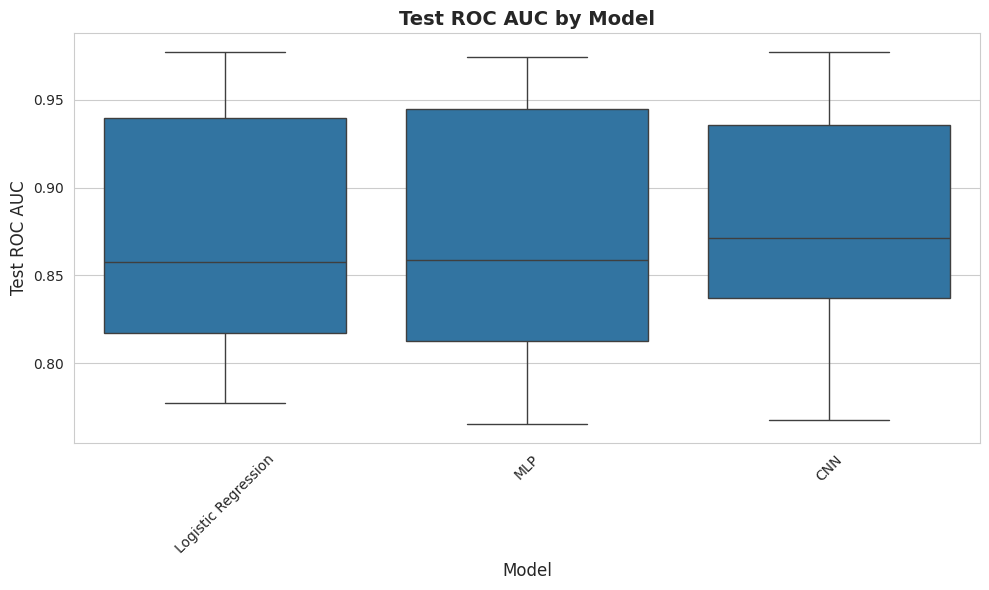

In [23]:
# Box plot: Test ROC AUC by Model
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='model_name', y='test_roc_auc')
plt.title('Test ROC AUC by Model', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test ROC AUC', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


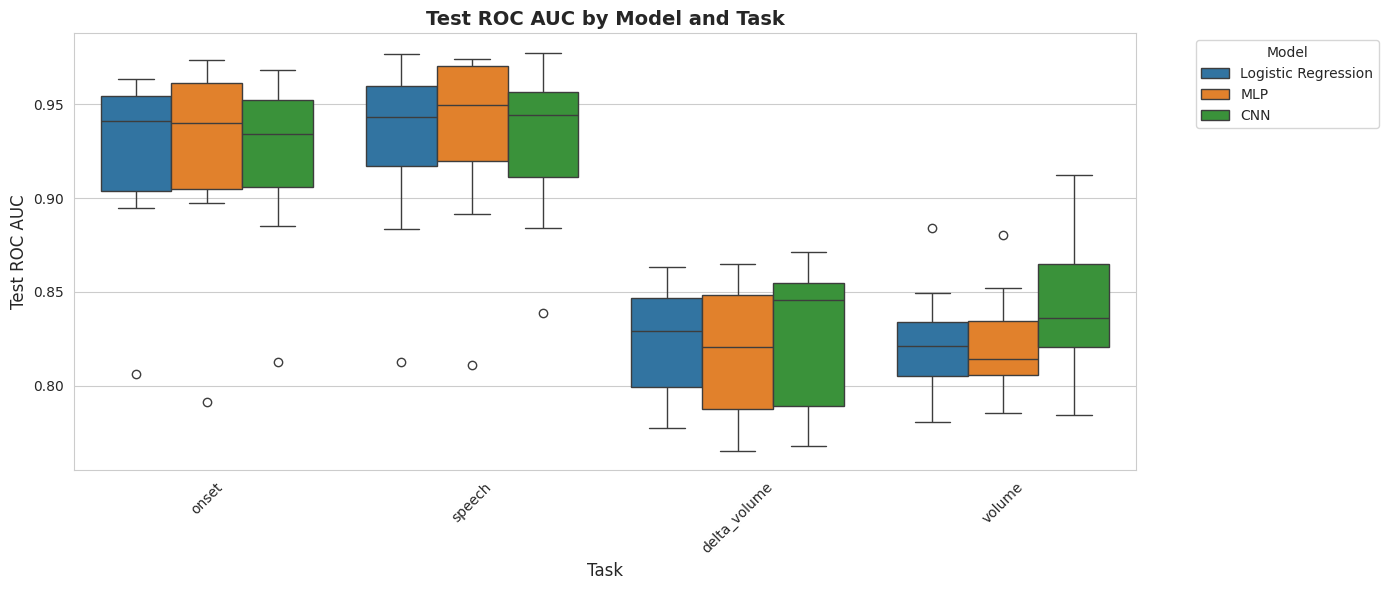

In [24]:
# Box plot: Test ROC AUC by Model and Task
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_all, x='eval_name', y='test_roc_auc', hue='model_name')
plt.title('Test ROC AUC by Model and Task', fontsize=14, fontweight='bold')
plt.xlabel('Task', fontsize=12)
plt.ylabel('Test ROC AUC', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


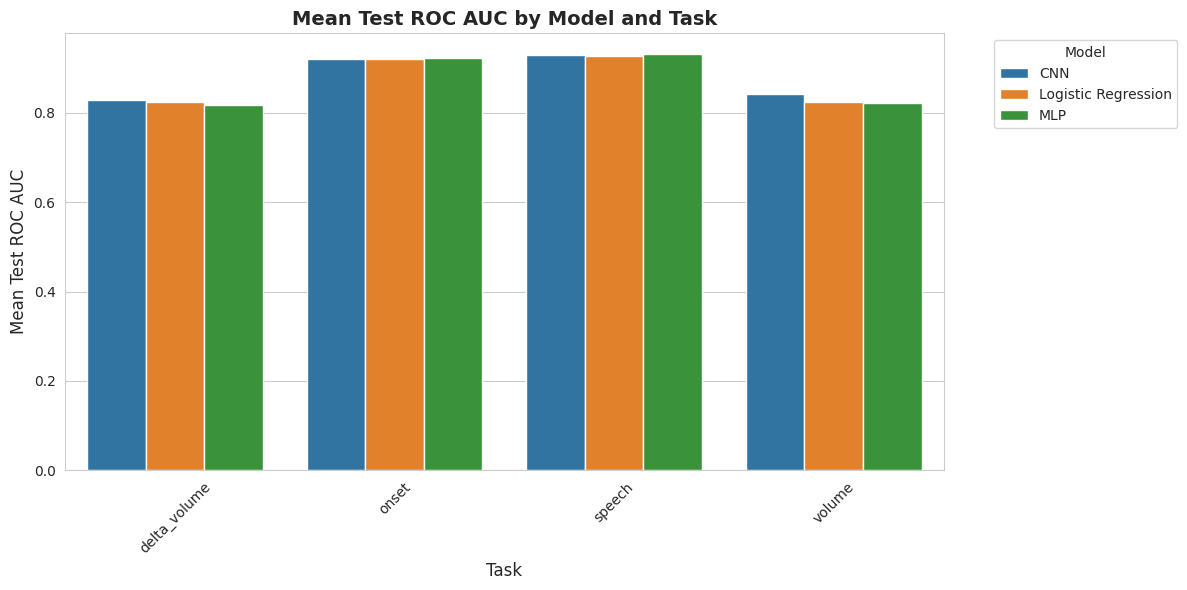

In [25]:
# Bar plot: Mean Test ROC AUC by Model and Task
mean_auc = df_all.groupby(['model_name', 'eval_name'])['test_roc_auc'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=mean_auc, x='eval_name', y='test_roc_auc', hue='model_name')
plt.title('Mean Test ROC AUC by Model and Task', fontsize=14, fontweight='bold')
plt.xlabel('Task', fontsize=12)
plt.ylabel('Mean Test ROC AUC', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


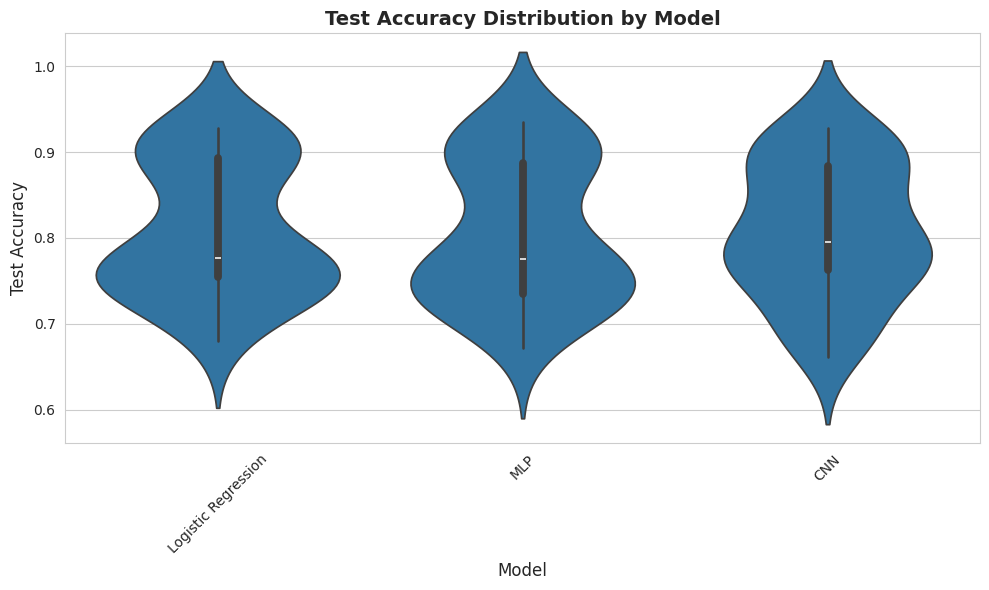

In [26]:
# Violin plot: Test Accuracy distribution by Model
plt.figure(figsize=(10, 6))
sns.violinplot(data=df_all, x='model_name', y='test_accuracy')
plt.title('Test Accuracy Distribution by Model', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


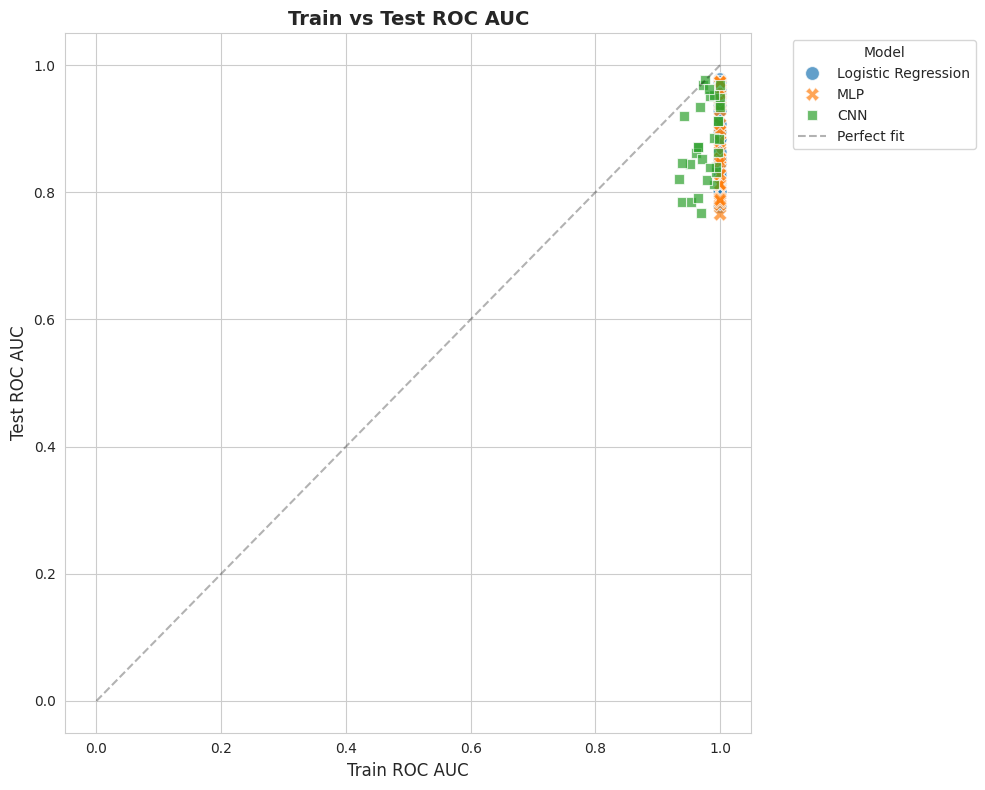

In [27]:
# Scatter plot: Train vs Test ROC AUC
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_all, x='train_roc_auc', y='test_roc_auc', 
                hue='model_name', style='model_name', s=100, alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect fit')
plt.title('Train vs Test ROC AUC', fontsize=14, fontweight='bold')
plt.xlabel('Train ROC AUC', fontsize=12)
plt.ylabel('Test ROC AUC', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


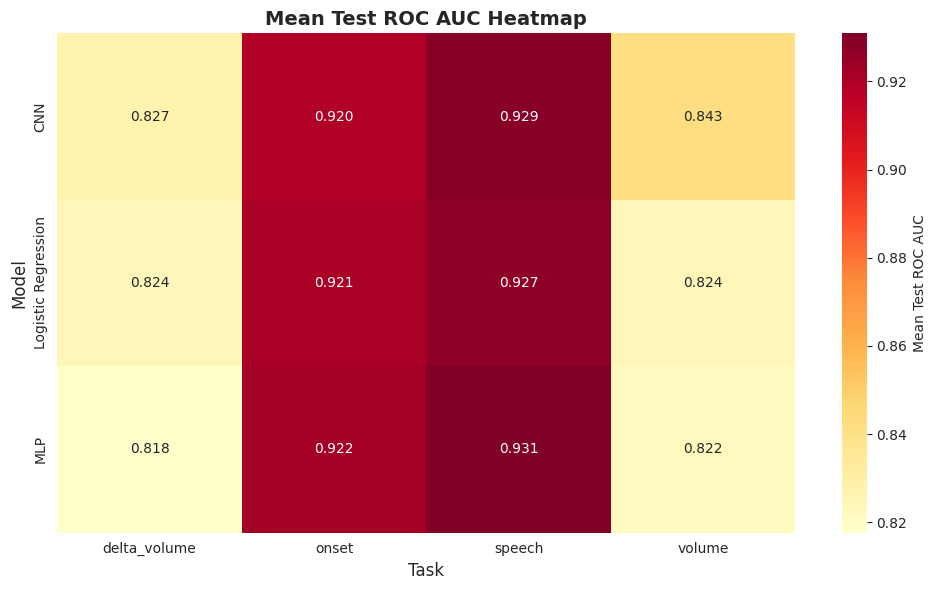

In [28]:
# Heatmap: Mean Test ROC AUC by Model and Task
pivot_table = df_all.pivot_table(
    values='test_roc_auc', 
    index='model_name', 
    columns='eval_name', 
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Mean Test ROC AUC'})
plt.title('Mean Test ROC AUC Heatmap', fontsize=14, fontweight='bold')
plt.xlabel('Task', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.tight_layout()
plt.show()


## Statistical Comparisons


In [29]:
# Compare models pairwise for each task
from scipy import stats

tasks = df_all['eval_name'].unique()
models = df_all['model_name'].unique()

comparisons = []
for task in tasks:
    task_data = df_all[df_all['eval_name'] == task]
    
    for i, model1 in enumerate(models):
        for model2 in models[i+1:]:
            model1_data = task_data[task_data['model_name'] == model1]['test_roc_auc']
            model2_data = task_data[task_data['model_name'] == model2]['test_roc_auc']
            
            if len(model1_data) > 0 and len(model2_data) > 0:
                # Perform t-test
                t_stat, p_value = stats.ttest_ind(model1_data, model2_data)
                
                comparisons.append({
                    'task': task,
                    'model1': model1,
                    'model2': model2,
                    'mean1': model1_data.mean(),
                    'mean2': model2_data.mean(),
                    'diff': model1_data.mean() - model2_data.mean(),
                    't_stat': t_stat,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                })

comparisons_df = pd.DataFrame(comparisons)
print("Pairwise Model Comparisons (t-test):")
comparisons_df.round(4)


Pairwise Model Comparisons (t-test):


,task,model1,model2,mean1,mean2,diff,t_stat,p_value,significant
0,onset,Logistic Regression,MLP,0.9210,0.9222,-0.0012,-0.0417,0.9673,False
1,onset,Logistic Regression,CNN,0.9210,0.9197,0.0013,0.0509,0.9601,False
2,onset,MLP,CNN,0.9222,0.9197,0.0025,0.0898,0.9297,False
3,speech,Logistic Regression,MLP,0.9270,0.9309,-0.0039,-0.1400,0.8907,False
4,speech,Logistic Regression,CNN,0.9270,0.9288,-0.0017,-0.0682,0.9466,False
5,speech,MLP,CNN,0.9309,0.9288,0.0021,0.0831,0.9350,False
6,delta_volume,Logistic Regression,MLP,0.8240,0.8176,0.0063,0.3791,0.7103,False
7,delta_volume,Logistic Regression,CNN,0.8240,0.8274,-0.0034,-0.1939,0.8490,False
8,delta_volume,MLP,CNN,0.8176,0.8274,-0.0098,-0.5112,0.6172,False
9,volume,Logistic Regression,MLP,0.8241,0.8218,0.0023,0.1436,0.8878,False


In [ ]:
# Save concatenated dataframe
df_all.to_csv('model_comparison_results.csv', index=False)
print("Saved results to 'model_comparison_results.csv'")

# Save summary statistics
summary.to_csv('model_comparison_summary.csv')
print("Saved summary to 'model_comparison_summary.csv'")
